# MNIST DATASET
#### What is the MNIST dataset?

The MNIST dataset or Modified National Institute of Standards and Technology dataset is a large collection of 60000 training images, and 10000 testing images. Half of the collection comprises of handwritten digits from the original NIST's training dataset and the other half is from its testing dataset. The NIST training dataset was taken from the American Census Bureau employees and the testing set was taken from American high school students, so the discrepancies between the two handwriting styles and quality was quite different. This is why the MNIST dataset is a mix of the two. Also the images were normalized, and centered to fit to a 28x28 pixel, which was also anti-aliased.

## Imports
For Keras, loading the dataset, saving the model, preprocessing and displaying.

In [1]:
# Seeding the model
import numpy as np
import tensorflow as tf
import random as rn
from keras import backend as K 
import os

# Training and reading the dataset
import keras as kr
from keras.models import load_model # To save and load models.
from keras.datasets import mnist # Import the MNIST dataset directly from Keras, which is faster.

import sklearn.preprocessing as pre # For encoding categorical variables.
import sklearn.decomposition as dec # For Principal component analysis (PCA) & Whitening

%matplotlib inline
import matplotlib.pyplot as plt # Plot results graphically.
import gzip # 
import pandas as pd # For displaying data sets.

Using TensorFlow backend.


## Reading the MNIST dataset
To learn more about how it works.

### Method 1: Read in the training and test images from gzip file (Slow)

* From testing this is quite slow compared to reading directly from keras.datasets which is used below, but it good for testing and learning how the dataset is structured.

In [2]:
# Adapted from: https://docs.python.org/3/library/gzip.html
# Open the MNIST dataset of 10000 testing images.
with gzip.open('MNIST_Images/t10k-images-idx3-ubyte.gz', 'rb') as f:
    test_imgs = f.read()

# Open the label dataset like before.
with gzip.open('MNIST_Images/t10k-labels-idx1-ubyte.gz', 'rb') as f:
    test_lbls = f.read()

#### Read in bytes from file.

In [3]:
# Print the file type of the dataset - bytes
print("File Type:", type(test_imgs))

# Print out the first four bytes.
# b'\x00\x00\x08\x03' is the output which correlates with the MNIST website results if reading from a gzip.
print("Bytes:", test_imgs[0:4])

File Type: <class 'bytes'>
Bytes: b'\x00\x00\x08\x03'


In [4]:
# Adapted from: https://stackoverflow.com/questions/51220161/how-to-convert-from-bytes-to-int
# Convert bytes to a 32 bit integer using big-endian and little-endian.
print("Big-endian:", int.from_bytes(test_imgs[0:4], byteorder='big')) #2051
print("Little-endian:", int.from_bytes(test_imgs[0:4], byteorder='little')) #50855936

Big-endian: 2051
Little-endian: 50855936


#### Display single image from dataset and label.

Image label: 0


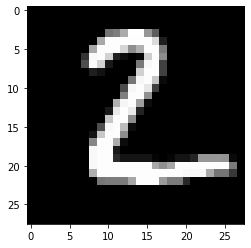

In [5]:
# Display a single image from the dataset
image = np.array(list(test_imgs[800:1584])).reshape(28,28).astype(np.uint8)

# Get the label for a specific image (Expected result = 4)
print("Image label:", int.from_bytes(test_lbls[1:2], byteorder="big"))

# Display plot of image
plt.imshow(image, cmap='gray')
plt.show()

### Method 2: Read in the training and test images from Keras directly.

* From testing this is considerably faster than reading from the gzip files in memory, so I have chosen this method.

* However when reading from the Keras directly there no header information in the first 16 bytes compared to when reading from the gzip, so it's hard to tell if you're reading it correctly.

In [6]:
(train_imgs, train_lbls), (test_imgs, test_lbls) = mnist.load_data()

## Seeding the model

From talking with our lecturer I found that it was best to seed the random weight generator to get reproducible results. As TensorFlow will automatically assign random weights on each run based on probibility. To achieve this I found documentation on the Keras website below, which I have adapted.

https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

The below is necessary for starting Numpy and core Python generated random numbers in a well-defined initial state.

In [7]:
np.random.seed(42)
rn.seed(12345)

Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
For further details, see: https://stackoverflow.com/questions/42022950/

In [8]:
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state. For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

In [9]:
tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

## Train the model

#### Set up a neural network model, building it layer by layer sequentially.

In [10]:
model = kr.models.Sequential()

#### Add Layers (Input & Hidden)
Add a hidden layer with 1000 neurons and an input layer with 784 inputs.
* 784 is the number of bytes per image (28 x 28)
* A dense layers means that each neuron recieves input from all the neurons in the previous layer (all connected)
* **linear activation function** = Takes the inputs, multiplied by the weights for each neuron, and creates an output proportional to the input. 
* **relu activation function** = (Rectified Linear Unit) All positive values stay the same and all negative values are changed to zero.

In [11]:
model.add(kr.layers.Dense(units=600, activation='linear', input_dim=784))
model.add(kr.layers.Dense(units=400, activation='relu')) 

#### Add Layers (Output)

Add a 10 neuron output layer, each output will represent a possible label from 0-9.
* **softmax** - normalizes all outputs so must add up to 1. So the largest weighted result will be the most probable number.
* E.g [0.1, 0.7, 0.1, 0.01...] it will choose 0.7

In [12]:
model.add(kr.layers.Dense(units=10, activation='softmax'))

#### Build the graph.
* **categorical_crossentropy** - loss function that is used for single label categorization. Used classification problems where only one result can be correct. E.g number is a 9
* **adam** - Computationally efficient and benefits from both AdaGrad and RMSProp optimizers.
* **accuracy** - Display accuracy results when training

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Parse image and labels into lists:
The bitwise operator (~ tilde) can be used to invert the image. It is a complement operator. It takes one bit operand and returns its complement. If the operand is 1, it returns 0, and if it is 0, it returns 1.

However I have left the image as is I.e black background with white digets, as from testing it makes prediction more accurate and the training accuracy is slighly higher.

Reshape each of the 60000 images into an array list of 28 x 28 bytes (pixels). Also reshape labels.

In [14]:
train_imgs = np.array(list(train_imgs[:])).reshape(60000, 28, 28).astype(np.uint8) / 255.0
train_lbls = np.array(list(train_lbls[:])).astype(np.uint8)
inputs = train_imgs.reshape(60000, 784)

### Preprocessing the dataset:
From watching the videos on Moodle relating to fine tuning models with scaling and Principal component analysis (PCA). I thought I would try it out myself to see the results, however from testing I have decided to not modify the data as it provides less accurate results unfortunately which is documented below.

Preprocessing is done as sometimes a value that has a variance which is substantially larger than others. This large value will dominate others making the neural network harder to learn from, as it might miss some of the less significant values.

#### Scaling the data:
Scaling the data involves standardizing the values. In each column the average for the column is taken away from each value and then divided by the standard deviation. The overall standard deviation should be 1, and the mean should be 0.

Code adapted from: https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing

In [15]:
# Scale inputs 
inputs_scaled = pre.scale(inputs)

# Get mean and std deviation which should be around 0 and 1
#pd.DataFrame(inputs_scaled.mean(axis=0))
#pd.DataFrame(inputs_scaled.std(axis=0))

In [16]:
# Display scaled array using Pandas
pd.DataFrame(inputs_scaled)

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.033171,-0.022463,-0.016069,-0.011432,-0.009007,-0.00577,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.033171,-0.022463,-0.016069,-0.011432,-0.009007,-0.00577,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.033171,-0.022463,-0.016069,-0.011432,-0.009007,-0.00577,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.033171,-0.022463,-0.016069,-0.011432,-0.009007,-0.00577,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.033171,-0.022463,-0.016069,-0.011432,-0.009007,-0.00577,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.033171,-0.022463,-0.016069,-0.011432,-0.009007,-0.00577,0.0,0.0,0.0,0.0
59996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.033171,-0.022463,-0.016069,-0.011432,-0.009007,-0.00577,0.0,0.0,0.0,0.0
59997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.033171,-0.022463,-0.016069,-0.011432,-0.009007,-0.00577,0.0,0.0,0.0,0.0
59998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.033171,-0.022463,-0.016069,-0.011432,-0.009007,-0.00577,0.0,0.0,0.0,0.0


#### Principal component analysis (PCA) & Whitening:

PCA involves transforming a number of correlated variables into a smaller uncorrelated variables which are called principal components.

Whitening involves multiplying each component by the square root and then dividing by the singular values which ensures uncorrelated outputs. Whitening will remove some information from the inputs, but can sometimes improve results.

In [17]:
# Whiten using sklearn.decomposition
pca = dec.PCA(whiten=True)
pca.fit(inputs)

# Covert to pandas dataframe and display.
inputs_white = pd.DataFrame(pca.transform(inputs))
inputs_white

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.214854,-0.633921,-0.053303,-1.292893,-0.066811,-0.604610,0.698640,0.508199,-1.181288,0.698025,...,1.934448e-15,0.0,0.0,0.0,0.0,-4.321313,14.340837,18.642379,0.349014,-3.397805
1,1.753950,-0.597798,1.296674,-1.071908,-2.024822,-0.473206,-0.134418,-0.333827,0.131477,0.531074,...,1.749181e-06,0.0,0.0,0.0,0.0,-0.037058,1.255922,6.270980,-4.164999,17.605331
2,-0.089888,0.795099,-0.409894,1.212060,-0.750626,-0.004773,-2.564855,1.172206,-0.372232,-0.627951,...,3.424522e-05,0.0,0.0,0.0,0.0,-0.018421,-10.340331,-8.907293,13.307287,5.379773
3,-1.385394,-1.231043,0.595024,0.246311,-0.004536,1.819619,-1.414364,-0.214098,0.983764,0.039087,...,1.606204e-06,0.0,0.0,0.0,0.0,0.044644,-3.454146,4.230403,6.892552,-4.518633
4,-0.663557,1.481116,0.035559,-0.562275,0.240258,0.112429,-0.273689,-1.289756,0.732797,0.366243,...,-2.176150e-05,0.0,0.0,0.0,0.0,-0.024908,-1.391055,2.147943,3.802038,3.453613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,-0.172708,-0.594998,0.295587,-0.807536,0.744740,0.616359,-1.488535,-0.755669,-1.608234,1.126865,...,-5.141710e-06,0.0,0.0,0.0,0.0,-0.241807,0.935214,-1.893164,-10.826239,9.247554
59996,0.264826,-1.394660,-0.193374,-1.512166,0.485618,0.480543,-1.454452,1.607075,-2.173570,0.095414,...,-7.413602e-06,0.0,0.0,0.0,0.0,0.104544,1.074031,-0.910176,4.538898,4.995267
59997,-0.308680,0.324545,-0.560151,-1.662534,-0.514763,-1.202745,-1.386961,-0.587777,-0.284422,0.943168,...,-1.211944e-07,0.0,0.0,0.0,0.0,-0.261956,3.507706,1.078574,1.789468,17.024285
59998,0.226423,-0.011337,1.117329,0.797252,-1.275595,-1.405840,-0.320593,0.447549,-0.053605,-0.330114,...,-7.671874e-06,0.0,0.0,0.0,0.0,0.029328,-9.675645,2.207996,4.522283,-5.258369


#### Results of Preprocessing image data:
**Scaling** - Training accuracy was quite high with a 97% accuracy but correct results only deemed 907 correct results out of 10000.

**PCA & Whitening** - Training accuracy was again quite high with a slighly higher accuracy of 98%. However once again the correct results only deemed 1204 correct results out of 10000, which is far too low.

**Conclusion** - From testing both methods multiple times the results didn't change much, so maybe too much information is being changed to give accurate results. When nothing is done to the dataset it gets on average 9700 correct which is what I will use. However it was a good learning experience.

### Encode labels:
Encode into binary using sklearn, so they can be compared easily.
E.g 0 = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1 = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] etc.

In [18]:
encoder = pre.LabelBinarizer()
encoder.fit(train_lbls)
outputs = encoder.transform(train_lbls)

In [19]:
train_lbls[0], outputs[0]

(5, array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0]))

#### Print out binary value for each number 0-9. 
As you can see each value from 0-9, with the 1 being the correct number index.

In [20]:
for i in range(10):
    print(i, encoder.transform([i]))

0 [[1 0 0 0 0 0 0 0 0 0]]
1 [[0 1 0 0 0 0 0 0 0 0]]
2 [[0 0 1 0 0 0 0 0 0 0]]
3 [[0 0 0 1 0 0 0 0 0 0]]
4 [[0 0 0 0 1 0 0 0 0 0]]
5 [[0 0 0 0 0 1 0 0 0 0]]
6 [[0 0 0 0 0 0 1 0 0 0]]
7 [[0 0 0 0 0 0 0 1 0 0]]
8 [[0 0 0 0 0 0 0 0 1 0]]
9 [[0 0 0 0 0 0 0 0 0 1]]


### Run and save the Model
Rather than retraining the model again and again I wanted to be able to save and load it, so I researched and found a way to achieve this, by saving a binary .h5 model file. This could then be loaded into the web application for quick prediction.

Code adapted from: https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

**One Epoch** - Is when an entire dataset is passed forward and backward through the neural network only once.
I have decided to train the model using 10 epochs, which from testing it seems to peak at. This can be seen in the graph below.

In [21]:
model_log = model.fit(inputs, outputs, verbose=2, epochs=10, batch_size=200)
model.save('trained_model.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/10
 - 5s - loss: 0.2436 - acc: 0.9277
Epoch 2/10
 - 4s - loss: 0.0998 - acc: 0.9698
Epoch 3/10
 - 4s - loss: 0.0685 - acc: 0.9783
Epoch 4/10
 - 4s - loss: 0.0544 - acc: 0.9826
Epoch 5/10
 - 4s - loss: 0.0478 - acc: 0.9843
Epoch 6/10
 - 4s - loss: 0.0376 - acc: 0.9877
Epoch 7/10
 - 4s - loss: 0.0342 - acc: 0.9889
Epoch 8/10
 - 4s - loss: 0.0301 - acc: 0.9898
Epoch 9/10
 - 4s - loss: 0.0309 - acc: 0.9896
Epoch 10/10
 - 4s - loss: 0.0234 - acc: 0.9921


#### Display accuracy and loss results on a graph
Code adapted from: https://towardsdatascience.com/a-simple-2d-cnn-for-mnist-digit-recognition-a998dbc1e79a

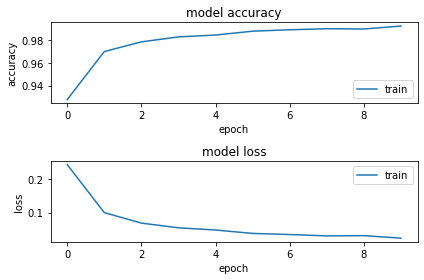

In [22]:
# plotting the metrics for accuracy and loss.
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(model_log.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(model_log.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

## Testing the trained model
Parse images and labels into lists, and reshape like before. This time using the 10000 training images and labels.

In [23]:
test_imgs = np.array(list(test_imgs[:])).reshape(10000, 784).astype(np.uint8) / 255.0
test_lbls = np.array(list(test_lbls[:])).astype(np.uint8)

#### Get the sum of correct values 
Calculate the sum of correct results out of all 10000 images using the labels

The last test returned a result of 9771, so it's about 97% of the time correct which correlates well with the accuracy results in the graph above.

In [24]:
print("\nSum of correct results:", (encoder.inverse_transform(model.predict(test_imgs)) == test_lbls).sum())


Sum of correct results: 9781


#### Predict image using model
Pick an image from the test images, and call predict. ([11:12], is the number 6)

In [25]:
print("\nTest image:", model.predict(test_imgs[11:12]))


Test image: [[1.2635444e-08 2.0018479e-19 5.1486220e-15 1.6143477e-16 3.0222049e-13
  2.2541767e-10 1.0000000e+00 2.2807827e-14 1.0179507e-08 3.1492902e-18]]


From testing the model.predict it would return an array of possibilities. The highest value would be the right answer.
To get the largest value I looked how to get the index of the highest value in a numpy array and found argmax() which does this nicely.

Code adapted from: https://kite.com/python/examples/5750/numpy-find-the-index-of-the-largest-element-of-an-array

In [26]:
print("\nResults:", model.predict(test_imgs[11:12]).argmax())


Results: 6


#### Display correct image 
If it's the same as the predicted above then the prediction is correct.

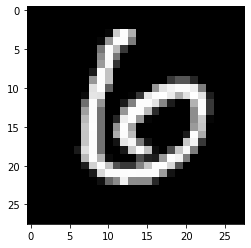

In [27]:
plt.imshow(test_imgs[11].reshape(28, 28), cmap='gray')
plt.show()